In [ ]:
!pip install umap-learn
!pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

In [ ]:
df = pd.read_csv("spotify.csv")
print("Dimensiones del dataset :", df.shape)
df.head()


Dimensiones del dataset : (999, 17)


,RANK,NAME,LANGUAGE,TYPE,MOST_STREAMED_GAME,2ND_MOST_STREAMED_GAME,AVERAGE_STREAM_DURATION,FOLLOWERS_GAINED_PER_STREAM,AVG_VIEWERS_PER_STREAM,AVG_GAMES_PER_STREAM,TOTAL_TIME_STREAMED,TOTAL_FOLLOWERS,TOTAL_VIEWS,TOTAL_GAMES_STREAMED,ACTIVE_DAYS_PER_WEEK,MOST_ACTIVE_DAY,DAY_WITH_MOST_FOLLOWERS_GAINED
0,1,kaicenat,English,personality,Just Chatting,I'm Only Sleeping,7.6,18.405,15.852,2.3,4.698,10600000,9150000,194,3.6,Friday,Saturday
1,2,jynxzi,English,personality,Tom Clancy's Rainbow Six Siege,NBA 2K20,5.4,3.386,1.145,1.2,8.407,5760000,1950000,54,5.6,Tuesday,Sunday
2,3,caedrel,English,personality,League of Legends,I'm Only Sleeping,6.3,689.000,12.331,1.3,6.728,797000,14200000,111,2.8,Thursday,Sunday
3,4,caseoh_,English,personality,NBA 2K23,Just Chatting,4.6,7.185,0.000,3.6,2.554,4220000,53,385,6.2,Friday,Monday
4,5,ibai,Spanish,personality,Just Chatting,League of Legends,4.1,8.289,190.714,1.5,6.865,15600000,359000000,149,4.3,Wednesday,Saturday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   RANK                            999 non-null    int64  
 1   NAME                            999 non-null    object 
 2   LANGUAGE                        999 non-null    object 
 3   TYPE                            999 non-null    object 
 4   MOST_STREAMED_GAME              999 non-null    object 
 5   2ND_MOST_STREAMED_GAME          922 non-null    object 
 6   AVERAGE_STREAM_DURATION         999 non-null    float64
 7   FOLLOWERS_GAINED_PER_STREAM     999 non-null    float64
 8   AVG_VIEWERS_PER_STREAM          999 non-null    float64
 9   AVG_GAMES_PER_STREAM            999 non-null    float64
 10  TOTAL_TIME_STREAMED             999 non-null    float64
 11  TOTAL_FOLLOWERS                 999 non-null    int64  
 12  TOTAL_VIEWS                     999 

In [ ]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


In [ ]:
df.isnull().sum()

RANK                               0
NAME                               0
LANGUAGE                           0
TYPE                               0
MOST_STREAMED_GAME                 0
2ND_MOST_STREAMED_GAME            77
AVERAGE_STREAM_DURATION            0
FOLLOWERS_GAINED_PER_STREAM        0
AVG_VIEWERS_PER_STREAM             0
AVG_GAMES_PER_STREAM               0
TOTAL_TIME_STREAMED                0
TOTAL_FOLLOWERS                    0
TOTAL_VIEWS                        0
TOTAL_GAMES_STREAMED               0
ACTIVE_DAYS_PER_WEEK               0
MOST_ACTIVE_DAY                    0
DAY_WITH_MOST_FOLLOWERS_GAINED     0
dtype: int64

In [ ]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,rank,name,language,type,most_streamed_game,2nd_most_streamed_game,average_stream_duration,followers_gained_per_stream,avg_viewers_per_stream,avg_games_per_stream,total_time_streamed,total_followers,total_views,total_games_streamed,active_days_per_week,most_active_day,day_with_most_followers_gained
0,1,kaicenat,English,personality,Just Chatting,I'm Only Sleeping,7.6,18.405,15.852,2.3,4.698,10600000,9150000,194,3.6,Friday,Saturday
1,2,jynxzi,English,personality,Tom Clancy's Rainbow Six Siege,NBA 2K20,5.4,3.386,1.145,1.2,8.407,5760000,1950000,54,5.6,Tuesday,Sunday
2,3,caedrel,English,personality,League of Legends,I'm Only Sleeping,6.3,689.000,12.331,1.3,6.728,797000,14200000,111,2.8,Thursday,Sunday
3,4,caseoh_,English,personality,NBA 2K23,Just Chatting,4.6,7.185,0.000,3.6,2.554,4220000,53,385,6.2,Friday,Monday
4,5,ibai,Spanish,personality,Just Chatting,League of Legends,4.1,8.289,190.714,1.5,6.865,15600000,359000000,149,4.3,Wednesday,Saturday


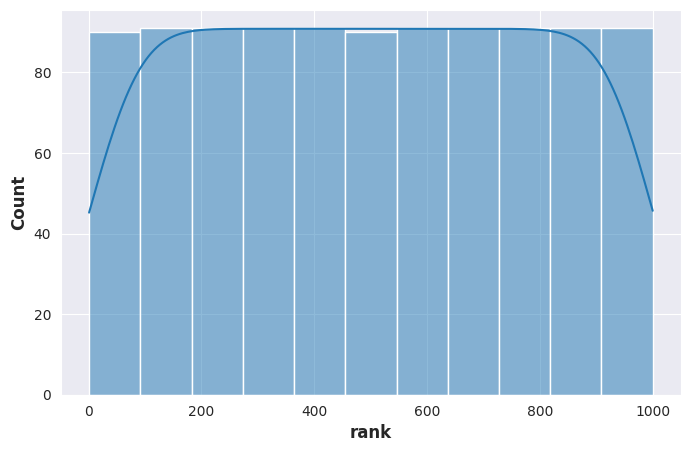

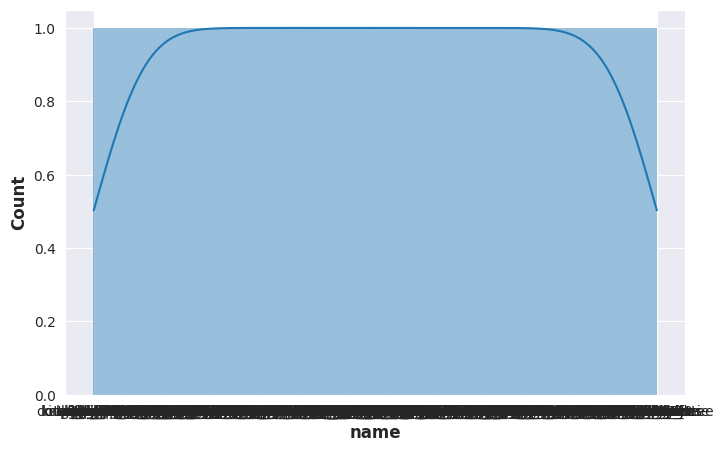

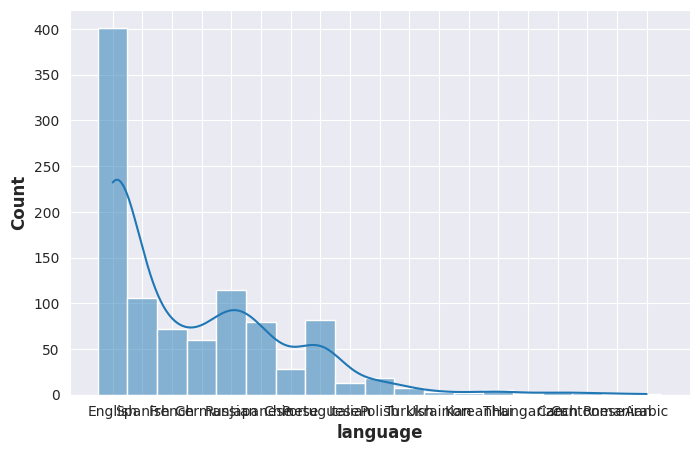

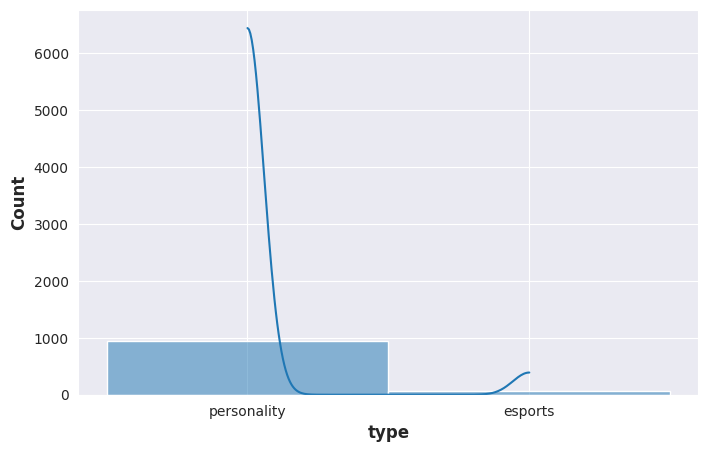

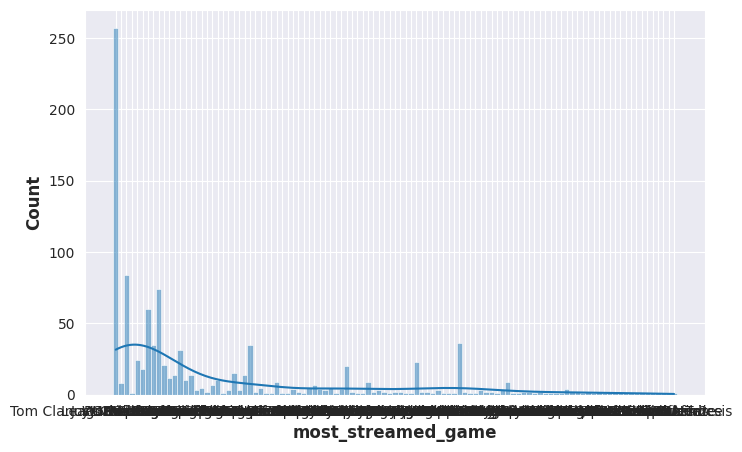

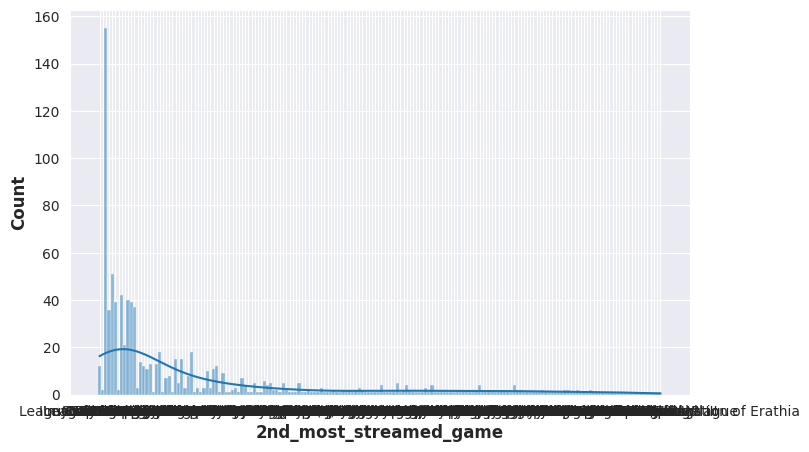

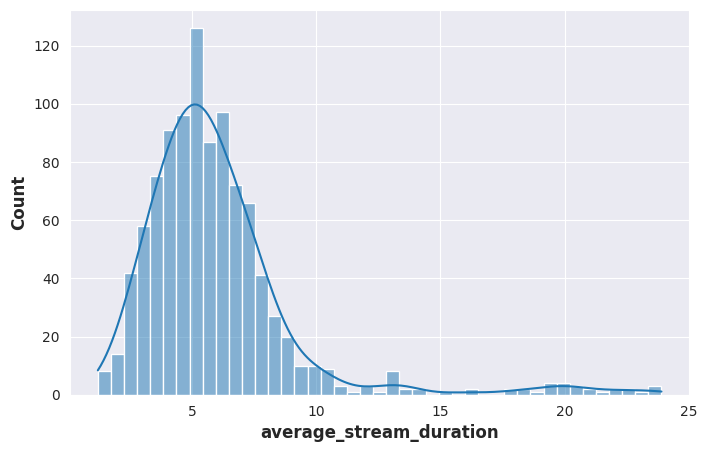

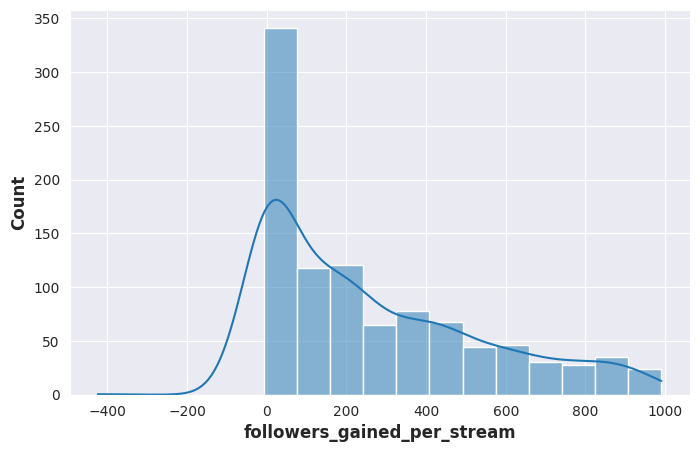

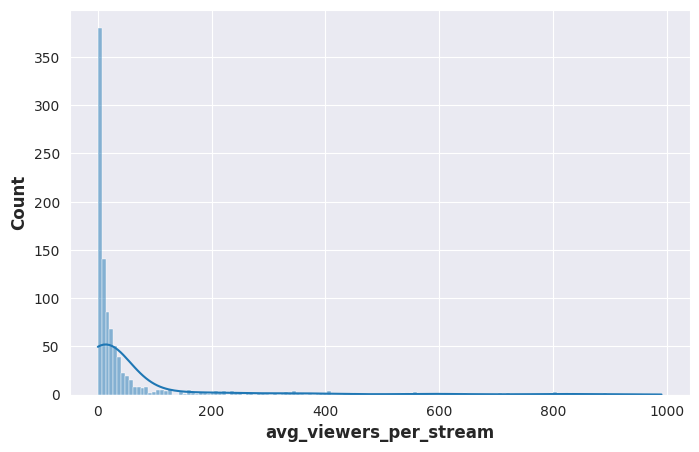

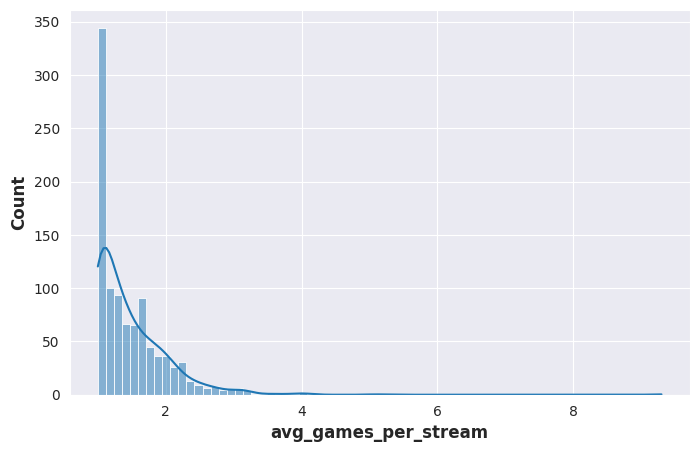

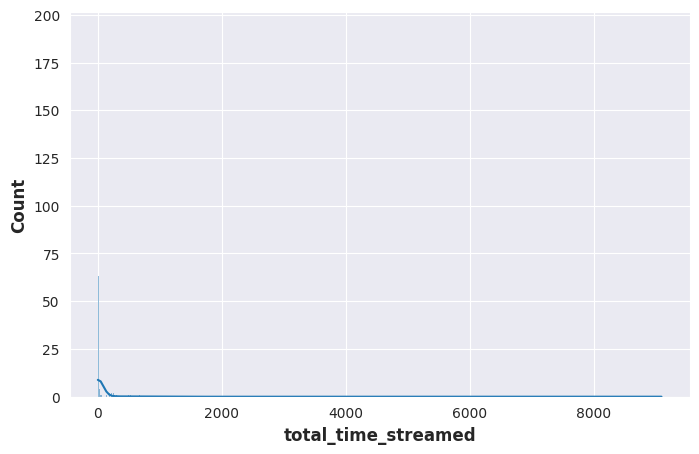

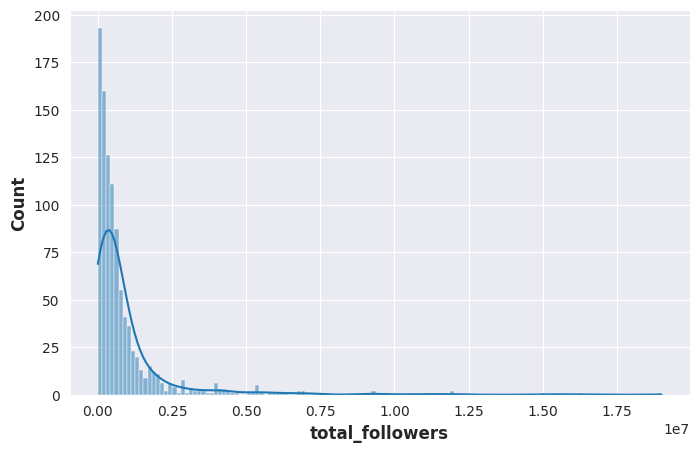

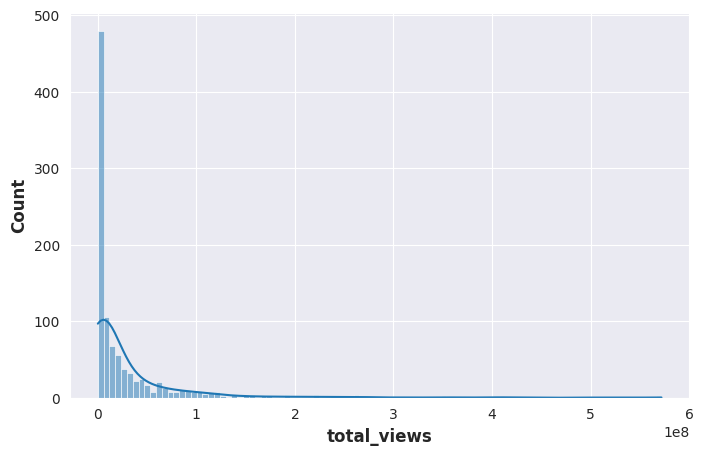

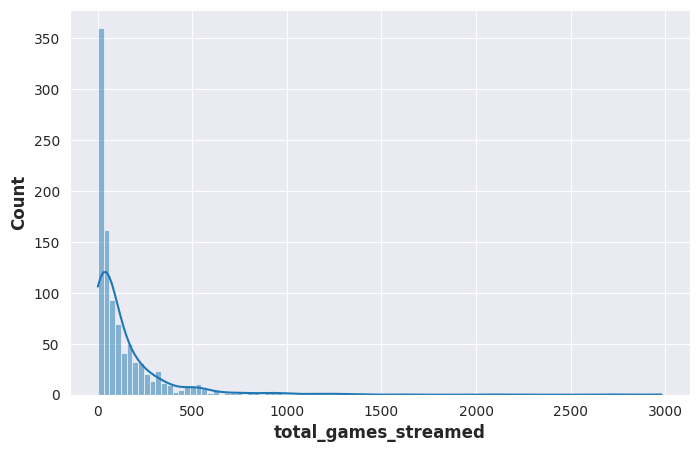

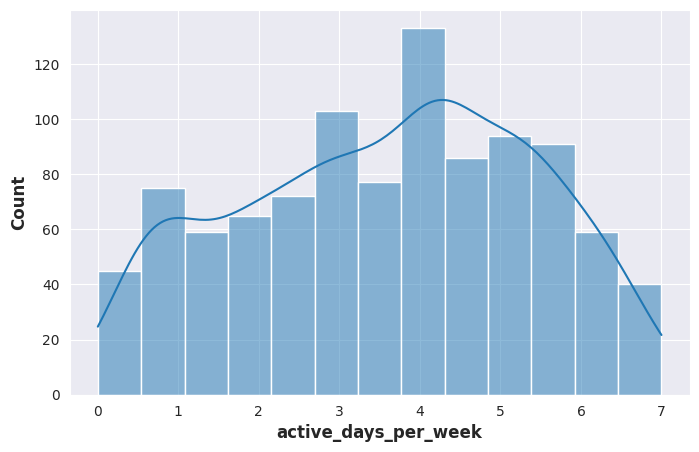

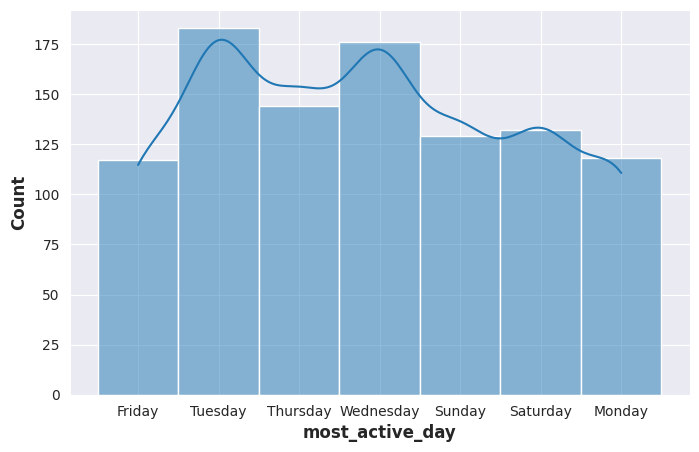

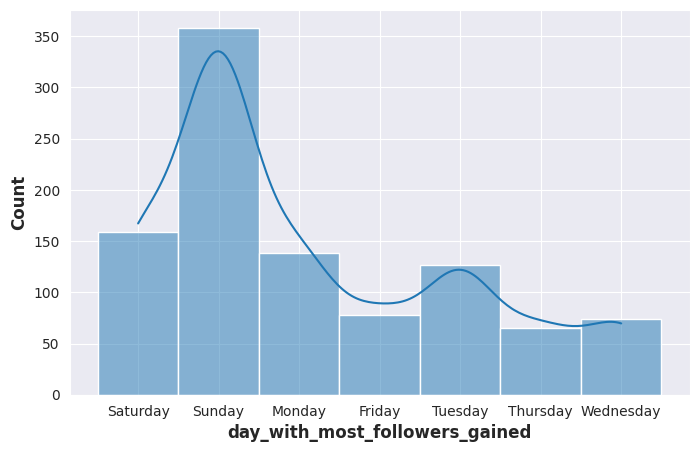

In [ ]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()


In [ ]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

In [ ]:
X = StandardScaler().fit_transform(df)

ValueError: could not convert string to float: 'kaicenat'

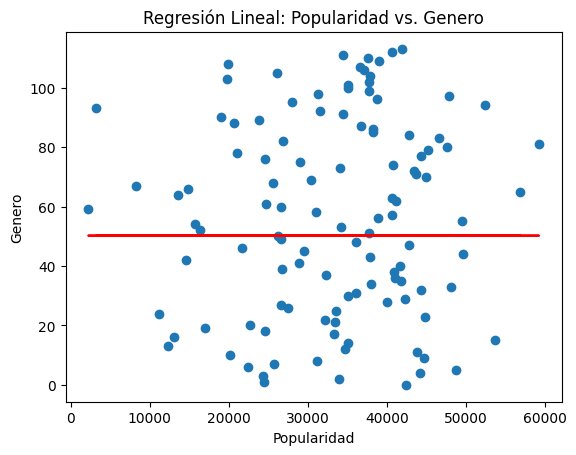

In [ ]:
from sklearn.linear_model import LinearRegression

modelo_regresion = LinearRegression()
modelo_regresion.fit(popularity.values.reshape(-1, 1), track_genre)

plt.scatter(popularity, track_genre)
plt.plot(popularity, modelo_regresion.predict(track_genre.values.reshape(-1, 1)), color='red')
plt.xlabel('Popularidad')
plt.ylabel('Genero')
plt.title('Regresión Lineal: Popularidad vs. Genero')
plt.show()

In [ ]:
df2.corr()


,track_genre_encoded,popularity_sum
track_genre_encoded,1.000000,0.064845
popularity_sum,0.064845,1.000000
